In [1]:
# from network.Gamma2DCropPaste import StackTPredict, UNet, StackSequenceT , Gamma2DCropPaste, Gamma2DNet
from network.mapGeneratorNet import LSTMNet, Generator, GeneratorPredict

import torch
import numpy as np 
from common.readFiles import *
from common.evaluateModelTools import *
from matplotlib import pyplot as plt
from policy.PytorchTraining import PytorchRunner
import matplotlib.ticker as ticker
from runner.loadLocalizeModel import getLocalizeModel
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
map_x = 5

variables = ["source_pos", "source_region", "X_input", "source_concentration", 
             "water_flow_force", "source_inside", "distance_map", "source_detect",
             "source_distance", "agent_action", "agent_position", "centroids", "source_detect"]


datas = []
file_type = "stochastic"
for map_x in [5, 10]:
    path = "../output/data/processedData/voroni/"+file_type+"/{}/".format(map_x)
    datas.append(getData(path, variables))

In [3]:
source_pos, source_region, X_input, source_concentration, water_flow_force, source_inside, distance_map, source_detect, source_distance, agent_action, agent_position, centroids, source_detect = datas[0]

In [4]:
torch.sum(source_inside)/np.prod(source_inside.shape)

tensor(0.8780)

In [5]:
def calculateError():
    def findAngle(A, B):
        cos_between = torch.sum(A * B, axis=-1) / (torch.norm(B, dim=-1) * torch.norm(A, dim=-1))
        error_angle = torch.arccos(cos_between)
        # error_angle[error_angle > np.pi/2] = np.pi - error_angle[error_angle > np.pi/2]
        error_angle[torch.isnan(error_angle)] = -1  # bsize, time_len
        return error_angle

    mask_inside_with_detect = source_inside * source_detect
    mask_inside_no_detect = source_inside * (1 - source_detect)
    mask_outside_with_detect = (1 - source_inside) * source_detect
    mask_outside_no_detect = (1 - source_inside) * (1 - source_detect)

    masks = [mask_inside_with_detect, mask_inside_no_detect, mask_outside_with_detect, mask_outside_no_detect]
    error_distance_list, error_angle_list = [], []

    predict_centroid = centroids[torch.argmax(normalized_predict, dim=-1)].to(DEVICE)  # bsize, time_len, 2
    # predict_centroid = agent_pos + predict_centroid  # bsize, time_len, 2

    # error distance
    error_distance = torch.nn.PairwiseDistance(p=2)(predict_centroid.reshape(-1, 2),
                                                    source_pos.reshape(-1, 2)).reshape(
        source_pos.shape[:-1])  # bsize, time_len
    error_angle = findAngle(predict_centroid, source_pos)  # bsize, time_len

    for mask in masks:
        distance_mask, angle_mask = mask, mask * (error_angle >= 0)

        avg_error_distance = torch.sum(error_distance * distance_mask) / torch.sum(distance_mask)
        avg_error_angle = torch.sum(error_angle * angle_mask) / torch.sum(angle_mask)

        error_distance_list.append(avg_error_distance.to('cpu').item())
        error_angle_list.append(avg_error_angle.to('cpu').item())

    return np.array(error_distance_list), np.array(error_angle_list)

def calculateSourceDistance():
    return torch.cdist(source_pos, torch.tensor([[0,0]], dtype=torch.float)).squeeze(-1)

In [6]:
runner_arg = {
    "new_loss" : True,
    "regularizer_constant": 0.01,
    "accuracy_range":0,
    "folder_path":"../output/ReportModel/stochastic/{}outOf{}/",
    "name":"LSTM"
}

def getPerformance(data, model_path,  distance = True, inside = 0):
    model = getLocalizeModel(model_path = model_path)
    LSTM_runner = PytorchRunner(runner_arg=runner_arg)
    LSTM_runner.modelInitialize(model)


    source_pos, source_region, X_input, source_concentration, water_flow_force, source_inside, distance_map, source_detect, source_distance, agent_action, agent_position, centroids, source_detect = data


    LSTM_runner.dataInitialize([X_input, agent_action, distance_map, source_region, source_pos, source_inside, source_detect])
    LSTM_runner.logDataInitialize([source_concentration, water_flow_force, centroids])

    X_input, agent_action, distance_map_final, source_region, source_pos, source_inside, source_detect = LSTM_runner.test_data



    LSTM_runner.valid, LSTM_runner.full_valid = LSTM_runner.X_input_valid_final_test, LSTM_runner.X_full_input_valid_final_test
    mask, error_distance, error_angle, source_distance, valid = LSTM_runner.runEp(LSTM_runner.test_data, log=LSTM_runner.test_log, evaluate = True)
    mask, error_distance, error_angle, source_distance, valid = mask.to('cpu'), error_distance.to('cpu'), error_angle.to('cpu'), source_distance.to('cpu'), valid.to('cpu')

    
    if isinstance(inside, tuple):
        evaluate_mask = (mask[inside[0]] + mask[inside[1]]).type(torch.bool)    
    else: evaluate_mask = mask[inside].type(torch.bool)
    evaluate_x = source_distance[evaluate_mask]

   
    if distance:
        evaluate_y = error_distance[evaluate_mask]
    else: evaluate_y = error_angle[evaluate_mask]

    x,y = kernelSmooth(evaluate_x, evaluate_y)
    return x, y



tensor(0.6345) tensor(1.)
tensor(0.6352) tensor(1.)
tensor(0.6345) tensor(1.)
tensor(0.6352) tensor(1.)
tensor(0.6345) tensor(1.)
tensor(0.6352) tensor(1.)


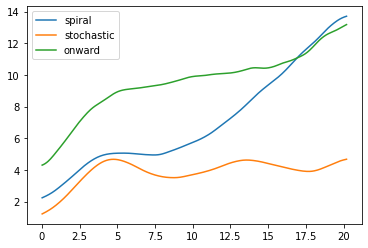

In [7]:
model_types = ['cyclone', 'stochastic', 'oneWay']
labels = ['spiral', 'stochastic', 'onward']

fig = plt.figure()
ax = fig.add_subplot(111)
map_x, new_loss, regularizer_constant = 5, False, 0

for (i, type) in enumerate(model_types):
    # for map_x in [5, 10]:
    model_path = path = "../output/ReportModel/{}/evaluate/modelWeight/model_{}_{}_{}.pth".format(type, map_x, new_loss, regularizer_constant)
    x, y = getPerformance(datas[0], model_path)
    
    ax.plot(x, y, label =labels[i])

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x * 0.1)))
ax.xaxis.set_major_formatter(ticks_x)

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x * 0.1)))
ax.yaxis.set_major_formatter(ticks_x)


plt.legend()

tensor(0.6345) tensor(1.)
tensor(0.6352) tensor(1.)
tensor(0.6345) tensor(1.)
tensor(0.6352) tensor(1.)
tensor(0.6345) tensor(1.)
tensor(0.6352) tensor(1.)


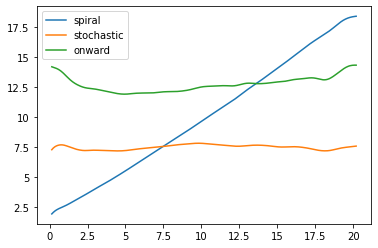

In [8]:
model_types = ['cyclone', 'stochastic', 'oneWay']
labels = ['spiral', 'stochastic', 'onward']

fig = plt.figure()
ax = fig.add_subplot(111)
map_x, new_loss, regularizer_constant = 5, False, 0

for (i, type) in enumerate(model_types):
    model_path = path = "../output/ReportModel/{}/evaluate/modelWeight/model_{}_{}_{}.pth".format(type, map_x, new_loss, regularizer_constant)
    x, y = getPerformance(datas[0], model_path, inside = 1)
    
    ax.plot(x, y, label =labels[i])

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x * 0.1)))
ax.xaxis.set_major_formatter(ticks_x)

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x * 0.1)))
ax.yaxis.set_major_formatter(ticks_x)


plt.legend()

In [ ]:
model_types = ['cyclone', 'stochastic', 'oneWay']
labels = ['spiral', 'stochastic', 'onward']

fig = plt.figure()
ax = fig.add_subplot(111)
map_x, new_loss, regularizer_constant = 5, False, 0

for (i, type) in enumerate(model_types):
    model_path = path = "../output/ReportModel/{}/evaluate/modelWeight/model_{}_{}_{}.pth".format(type, map_x, new_loss, regularizer_constant)
    x, y = getPerformance(datas[0], model_path, inside = (0, 2), distance= False)
    
    ax.plot(x, y, label =labels[i])

ax.set_ylim(0, 130)
ax.set_xlabel("source distance (m)")
ax.set_ylabel("distance error (m)")
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x * 0.1)))
ax.xaxis.set_major_formatter(ticks_x)

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x * 0.1)))
ax.yaxis.set_major_formatter(ticks_x)


plt.legend()